In [278]:
!pip3 install scikit-learn tqdm catboost optuna xgboost ipywidgets imblearn
# 모델을 위해 필요한 라이브러리 설치(우수 예시에만 있는 부분)

In [290]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler

In [291]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed=42
seed_everything(seed) # Seed 고정

In [292]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [293]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
    
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

        
def manage_label_encoding(df_train, df_test):
    tmp = len(df_train)
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    
    df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    
    for col in label_columns:  
        df_train[col] = df_all.iloc[: tmp][col]
        df_test[col] = df_all.iloc[tmp :][col]

    return df_train, df_test

def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',  # merge into 'less than 3 months'
        'being followed up': 'being followed up.',  # merge into 'being followed up.'
        'less than 6 months': '3 months ~ 6 months',  # merge into '3 months ~ 6 months'
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    ]
    
    ###############################
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')
    
    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    
    #RobustScaler
    robustScaler = RobustScaler()
    df_train['ver_win_rate_x'] = robustScaler.fit_transform(df_train[['ver_win_rate_x']])
    df_test['ver_win_rate_x'] = robustScaler.transform(df_test[['ver_win_rate_x']])
    robustScaler = RobustScaler()
    df_train['ver_win_ratio_per_bu'] = robustScaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
    df_test['ver_win_ratio_per_bu'] = robustScaler.transform(df_test[['ver_win_ratio_per_bu']])
    ###############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)

In [294]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55780 entries, 0 to 55779
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   bant_submit              55780 non-null  float64 
 1   customer_country         55780 non-null  category
 2   business_unit            55780 non-null  category
 3   com_reg_ver_win_rate     55780 non-null  float64 
 4   customer_idx             55780 non-null  category
 5   customer_type            55780 non-null  category
 6   enterprise               55780 non-null  category
 7   historical_existing_cnt  55780 non-null  int64   
 8   id_strategic_ver         55780 non-null  category
 9   it_strategic_ver         55780 non-null  category
 10  idit_strategic_ver       55780 non-null  category
 11  customer_job             55780 non-null  category
 12  lead_desc_length         55780 non-null  int64   
 13  inquiry_type             55780 non-null  category
 14  product_cat

In [295]:
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
def custom_split(df_train, num=5, idx=0, smote=False, false_rate=1):
    global rate

    #shuffle
    true_df_train = sklearn.utils.shuffle(df_train[df_train["is_converted"]==True], random_state=seed)
    false_df_train = sklearn.utils.shuffle(df_train[df_train["is_converted"]==False], random_state=seed)
    
    #k-fold num
    slice_num = len(true_df_train) // num
    
    #True:False = 1:1
    tmp_train = pd.concat([true_df_train[0:slice_num*idx],
                           true_df_train[slice_num*(idx+1):],
                           false_df_train[0:int((slice_num*false_rate)*idx)],
                           false_df_train[int((slice_num*false_rate)*(idx+1)):]])
    tmp_val = pd.concat([true_df_train[slice_num*idx:slice_num*(idx+1)],
                         false_df_train[int((slice_num*false_rate)*idx):int((slice_num*false_rate)*(idx+1))]])
    #shuffle
    tmp_train = sklearn.utils.shuffle(tmp_train, random_state=seed)
    tmp_val = sklearn.utils.shuffle(tmp_val, random_state=seed)

    #split x and y
    x_train, y_train = tmp_train.drop("is_converted",axis=1), tmp_train["is_converted"]
    x_val, y_val = tmp_val.drop("is_converted",axis=1), tmp_val["is_converted"]
    
    if(smote):
        sm = BorderlineSMOTE(random_state=seed)
        x_train, y_train = sm.fit_resample(x_train, y_train)
    categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                            'id_strategic_ver',
                                            'it_strategic_ver',
                                            'idit_strategic_ver',
                                            'ver_cus',
                                            'ver_pro',
                                        ]
    train_pool = Pool(data=x_train, label=y_train, cat_features=categorical_features)
    val_pool = Pool(data=x_val, label=y_val, cat_features=categorical_features)

    return train_pool, val_pool, list(y_val)


all_train_pool = []
all_val_pool = []
all_y_val = []
k_fold_num = 10
for idx in range(k_fold_num):
    bundle = custom_split(df_train, num=k_fold_num, idx=idx, smote=False, false_rate=rate)
    all_train_pool.append(bundle[0])
    all_val_pool.append(bundle[1])
    all_y_val.append(bundle[2])

In [296]:
def objective(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 1000, 30000),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.001, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-8,100),
        'random_strength': trial.suggest_uniform('random_strength',0,100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'verbose':False,
        'random_state':seed,
    }
    
    score = []
    tmp_score = []
    for train_pool, val_pool, y_true in zip(all_train_pool, all_val_pool, all_y_val):
        clf = CatBoostClassifier(**params,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 task_type="GPU",
                                 devices='0',
                                early_stopping_rounds=50, 
                                )
        clf.fit(train_pool, eval_set=val_pool)
        
        y_pred = clf.predict(val_pool)
        y_pred = [False if i=='False' else True for i in y_pred]
        tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
        score.append((f1_score(y_true,y_pred,labels=[True, False])+recall_score(y_true,y_pred))/2)
    score = np.mean(score)
    print(np.mean(tmp_score))
    return score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=None)

[I 2024-02-09 20:09:08,375] A new study created in memory with name: no-name-f3e39d91-6a4d-4033-8100-34e2a7b4596c
[I 2024-02-09 20:09:22,288] Trial 0 finished with value: 0.8530150182666446 and parameters: {'iterations': 11862, 'learning_rate': 0.9507635921035062, 'reg_lambda': 73.19939418382057, 'random_strength': 59.86584841970366, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.017073967431528128}. Best is trial 0 with value: 0.8530150182666446.


0.7538655343687869


[I 2024-02-09 20:09:42,047] Trial 1 finished with value: 0.8594553006037884 and parameters: {'iterations': 26119, 'learning_rate': 0.6015138967314656, 'reg_lambda': 70.80725778252382, 'random_strength': 2.0584494295802447, 'min_data_in_leaf': 97, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.07068974950624607}. Best is trial 1 with value: 0.8594553006037884.


0.7702093025062784


[I 2024-02-09 20:10:06,814] Trial 2 finished with value: 0.844760279509843 and parameters: {'iterations': 6273, 'learning_rate': 0.18422110534358038, 'reg_lambda': 30.42422430291135, 'random_strength': 52.475643163223786, 'min_data_in_leaf': 44, 'leaf_estimation_iterations': 5, 'bagging_temperature': 2.801635158716261}. Best is trial 1 with value: 0.8594553006037884.


0.7412521607512879


[I 2024-02-09 20:10:27,765] Trial 3 finished with value: 0.8565632299393677 and parameters: {'iterations': 5045, 'learning_rate': 0.29285250388668294, 'reg_lambda': 36.63618433570556, 'random_strength': 45.606998421703594, 'min_data_in_leaf': 79, 'leaf_estimation_iterations': 3, 'bagging_temperature': 1.1400863701127328}. Best is trial 1 with value: 0.8594553006037884.


0.7611784079306837


[I 2024-02-09 20:10:35,191] Trial 4 finished with value: 0.7109518671966885 and parameters: {'iterations': 18180, 'learning_rate': 0.047403962307277725, 'reg_lambda': 60.754485194068394, 'random_strength': 17.052412368729154, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 15, 'bagging_temperature': 72.86653737491046}. Best is trial 1 with value: 0.8594553006037884.


0.7584838209734636


[I 2024-02-09 20:10:52,735] Trial 5 finished with value: 0.8542372513432719 and parameters: {'iterations': 24444, 'learning_rate': 0.30530915540419734, 'reg_lambda': 9.767211409661668, 'random_strength': 68.42330265121569, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 2, 'bagging_temperature': 0.9565499215943827}. Best is trial 1 with value: 0.8594553006037884.


0.759773203985245


[I 2024-02-09 20:11:06,661] Trial 6 finished with value: 0.8413441650655387 and parameters: {'iterations': 1997, 'learning_rate': 0.9094110816767033, 'reg_lambda': 25.877998167413896, 'random_strength': 66.2522284353982, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 8, 'bagging_temperature': 1.5375920235481764}. Best is trial 1 with value: 0.8594553006037884.


0.7441601916029388


[I 2024-02-09 20:11:14,005] Trial 7 finished with value: 0.7109518671966885 and parameters: {'iterations': 6360, 'learning_rate': 0.969615043136794, 'reg_lambda': 77.51328233836013, 'random_strength': 93.9498941564189, 'min_data_in_leaf': 90, 'leaf_estimation_iterations': 9, 'bagging_temperature': 48.696409415209004}. Best is trial 1 with value: 0.8594553006037884.


0.7584838209734636


[I 2024-02-09 20:11:50,611] Trial 8 finished with value: 0.7567934011636511 and parameters: {'iterations': 3566, 'learning_rate': 0.19678687955672605, 'reg_lambda': 4.522728900601534, 'random_strength': 32.53303307632643, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 5, 'bagging_temperature': 20.651425578959262}. Best is trial 1 with value: 0.8594553006037884.


0.6042794430199429


[I 2024-02-09 20:11:57,466] Trial 9 finished with value: 0.7109518671966885 and parameters: {'iterations': 11346, 'learning_rate': 0.2816535751776934, 'reg_lambda': 54.26960832039789, 'random_strength': 14.092422497476264, 'min_data_in_leaf': 81, 'leaf_estimation_iterations': 2, 'bagging_temperature': 88.62326508576255}. Best is trial 1 with value: 0.8594553006037884.


0.7584838209734636


[I 2024-02-09 20:12:15,503] Trial 10 finished with value: 0.8584199825817361 and parameters: {'iterations': 29387, 'learning_rate': 0.6556785267510751, 'reg_lambda': 96.95371107909124, 'random_strength': 1.7961875614819434, 'min_data_in_leaf': 65, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.021064468501944014}. Best is trial 1 with value: 0.8594553006037884.


0.7674893158128232


[I 2024-02-09 20:12:31,984] Trial 11 finished with value: 0.8536040525714641 and parameters: {'iterations': 29432, 'learning_rate': 0.6272567612616611, 'reg_lambda': 99.74654747662224, 'random_strength': 0.8747366968610667, 'min_data_in_leaf': 67, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.01875348045209675}. Best is trial 1 with value: 0.8594553006037884.


0.7572081051429285


[I 2024-02-09 20:12:49,511] Trial 12 finished with value: 0.8561449178467825 and parameters: {'iterations': 29820, 'learning_rate': 0.6277679970235266, 'reg_lambda': 99.45420872881476, 'random_strength': 0.43462278479123495, 'min_data_in_leaf': 63, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.09470314305954813}. Best is trial 1 with value: 0.8594553006037884.


0.7618569352606647


[I 2024-02-09 20:13:05,253] Trial 13 finished with value: 0.8542195435550275 and parameters: {'iterations': 22947, 'learning_rate': 0.6923736143258277, 'reg_lambda': 80.9773397051379, 'random_strength': 26.146514454869475, 'min_data_in_leaf': 99, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.08101324842116016}. Best is trial 1 with value: 0.8594553006037884.


0.7625516412226091


[I 2024-02-09 20:13:22,782] Trial 14 finished with value: 0.8564872918197501 and parameters: {'iterations': 24212, 'learning_rate': 0.4680293148649111, 'reg_lambda': 87.17031008883396, 'random_strength': 12.870997019648975, 'min_data_in_leaf': 62, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.11516744025981103}. Best is trial 1 with value: 0.8594553006037884.


0.7612429819078985


[I 2024-02-09 20:13:42,230] Trial 15 finished with value: 0.8563806441153808 and parameters: {'iterations': 19696, 'learning_rate': 0.7647770038281734, 'reg_lambda': 63.634222628284014, 'random_strength': 34.92963122689709, 'min_data_in_leaf': 100, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.25327114788599464}. Best is trial 1 with value: 0.8594553006037884.


0.7712028466723203


[I 2024-02-09 20:14:00,832] Trial 16 finished with value: 0.8574279772452815 and parameters: {'iterations': 26731, 'learning_rate': 0.4739655146776491, 'reg_lambda': 88.05713128791625, 'random_strength': 85.73911300093486, 'min_data_in_leaf': 79, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.011065136021090997}. Best is trial 1 with value: 0.8594553006037884.


0.7644230540576624


[I 2024-02-09 20:14:17,230] Trial 17 finished with value: 0.8546822854227012 and parameters: {'iterations': 19996, 'learning_rate': 0.7963976000342017, 'reg_lambda': 46.416649609853486, 'random_strength': 7.018847425761147, 'min_data_in_leaf': 57, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.038578655738148664}. Best is trial 1 with value: 0.8594553006037884.


0.7641264756073072


[I 2024-02-09 20:14:34,869] Trial 18 finished with value: 0.8547984639017203 and parameters: {'iterations': 26880, 'learning_rate': 0.5558050716155853, 'reg_lambda': 66.87918727852504, 'random_strength': 21.263036293030744, 'min_data_in_leaf': 73, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.29823400101962777}. Best is trial 1 with value: 0.8594553006037884.


0.765008183214696


[I 2024-02-09 20:14:53,886] Trial 19 finished with value: 0.8601878806359344 and parameters: {'iterations': 21979, 'learning_rate': 0.4208939005131713, 'reg_lambda': 90.7705661422377, 'random_strength': 32.01560045100456, 'min_data_in_leaf': 27, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.0453129298652518}. Best is trial 19 with value: 0.8601878806359344.


0.7675619084580163


[I 2024-02-09 20:15:14,329] Trial 20 finished with value: 0.8593682870181683 and parameters: {'iterations': 15257, 'learning_rate': 0.40548311062258774, 'reg_lambda': 87.42317790677313, 'random_strength': 36.06791970055565, 'min_data_in_leaf': 24, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.3546395061909741}. Best is trial 19 with value: 0.8601878806359344.


0.7689530242527869


[I 2024-02-09 20:15:36,151] Trial 21 finished with value: 0.859792369637266 and parameters: {'iterations': 14850, 'learning_rate': 0.4042311481152849, 'reg_lambda': 87.56509453832098, 'random_strength': 41.94405354308335, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.28547622963343294}. Best is trial 19 with value: 0.8601878806359344.


0.7726150423048352


[I 2024-02-09 20:15:54,583] Trial 22 finished with value: 0.8593762531385423 and parameters: {'iterations': 15967, 'learning_rate': 0.409464869517336, 'reg_lambda': 71.88250774994415, 'random_strength': 44.53483830941985, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.07023338285185876}. Best is trial 19 with value: 0.8601878806359344.


0.7668044543290323


[I 2024-02-09 20:16:12,232] Trial 23 finished with value: 0.8574213570787954 and parameters: {'iterations': 21679, 'learning_rate': 0.5459361553349446, 'reg_lambda': 82.96563357063496, 'random_strength': 29.700838112440344, 'min_data_in_leaf': 25, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.1910666891568116}. Best is trial 19 with value: 0.8601878806359344.


0.765059164374041


[I 2024-02-09 20:16:33,894] Trial 24 finished with value: 0.8604646623765284 and parameters: {'iterations': 11277, 'learning_rate': 0.38215257439038874, 'reg_lambda': 49.629685339591376, 'random_strength': 41.62907372940295, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.5258678603570075}. Best is trial 24 with value: 0.8604646623765284.


0.7726609264846586


[I 2024-02-09 20:16:52,544] Trial 25 finished with value: 0.8583897712810915 and parameters: {'iterations': 10558, 'learning_rate': 0.382267762186216, 'reg_lambda': 45.93693073168638, 'random_strength': 56.01736265341834, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.6455139022118254}. Best is trial 24 with value: 0.8604646623765284.


0.7663466421292825


[I 2024-02-09 20:17:18,590] Trial 26 finished with value: 0.8408457356138379 and parameters: {'iterations': 8991, 'learning_rate': 0.17523624594440537, 'reg_lambda': 18.032774343889518, 'random_strength': 40.190540237705314, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 5, 'bagging_temperature': 3.648551942579751}. Best is trial 24 with value: 0.8604646623765284.


0.7342888738250786


[I 2024-02-09 20:17:57,179] Trial 27 finished with value: 0.790548325952565 and parameters: {'iterations': 14289, 'learning_rate': 0.019293885892421092, 'reg_lambda': 59.171234489076205, 'random_strength': 75.108108745223, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 7, 'bagging_temperature': 6.701379095869707}. Best is trial 24 with value: 0.8604646623765284.


0.6336940545025326


[I 2024-02-09 20:18:18,817] Trial 28 finished with value: 0.8622193609188031 and parameters: {'iterations': 13708, 'learning_rate': 0.3479168736274022, 'reg_lambda': 39.45305852033996, 'random_strength': 48.31238246508907, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.6588364117352957}. Best is trial 28 with value: 0.8622193609188031.


0.7740058214047059


[I 2024-02-09 20:18:45,914] Trial 29 finished with value: 0.8528312288165143 and parameters: {'iterations': 12877, 'learning_rate': 0.12907135372414846, 'reg_lambda': 39.15563307168418, 'random_strength': 62.38515922848655, 'min_data_in_leaf': 36, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.5767344855922646}. Best is trial 28 with value: 0.8622193609188031.


0.7526321546027253


[I 2024-02-09 20:19:13,134] Trial 30 finished with value: 0.800571243187121 and parameters: {'iterations': 8474, 'learning_rate': 0.3299469031296288, 'reg_lambda': 41.9559385115907, 'random_strength': 49.276450213554526, 'min_data_in_leaf': 52, 'leaf_estimation_iterations': 4, 'bagging_temperature': 10.046753651958149}. Best is trial 28 with value: 0.8622193609188031.


0.6680256032573586


[I 2024-02-09 20:19:32,554] Trial 31 finished with value: 0.8608717205183879 and parameters: {'iterations': 18142, 'learning_rate': 0.36086795462126847, 'reg_lambda': 54.009440120515386, 'random_strength': 39.69906025315887, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.5430278926785758}. Best is trial 28 with value: 0.8622193609188031.


0.7713105406038756


[I 2024-02-09 20:19:51,388] Trial 32 finished with value: 0.8512327345738747 and parameters: {'iterations': 17629, 'learning_rate': 0.5011227453270327, 'reg_lambda': 52.15783539460375, 'random_strength': 57.31079301042796, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 8, 'bagging_temperature': 1.9713831628745215}. Best is trial 28 with value: 0.8622193609188031.


0.7559286726109529


[I 2024-02-09 20:20:14,396] Trial 33 finished with value: 0.8587422098778325 and parameters: {'iterations': 12827, 'learning_rate': 0.24455417998744094, 'reg_lambda': 30.998288673141143, 'random_strength': 49.252863061003566, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.5485322301766777}. Best is trial 28 with value: 0.8622193609188031.


0.765536367807613


[I 2024-02-09 20:20:35,340] Trial 34 finished with value: 0.8602723455266161 and parameters: {'iterations': 20054, 'learning_rate': 0.33725273655028437, 'reg_lambda': 24.675703654331958, 'random_strength': 38.11112055702607, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.1552809414754725}. Best is trial 28 with value: 0.8622193609188031.


0.7716269421354831


[I 2024-02-09 20:20:57,673] Trial 35 finished with value: 0.862985924464566 and parameters: {'iterations': 17015, 'learning_rate': 0.33894490308390024, 'reg_lambda': 19.27076539492493, 'random_strength': 24.437706449348912, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.16410855807489796}. Best is trial 35 with value: 0.862985924464566.


0.775755398712682


[I 2024-02-09 20:21:30,199] Trial 36 finished with value: 0.8517570677645254 and parameters: {'iterations': 16866, 'learning_rate': 0.09509598265130931, 'reg_lambda': 16.544460789145134, 'random_strength': 25.489325973848125, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.8862754633455546}. Best is trial 35 with value: 0.862985924464566.


0.7517825337974491


[I 2024-02-09 20:21:56,876] Trial 37 finished with value: 0.8413262918162164 and parameters: {'iterations': 10071, 'learning_rate': 0.2115282189228257, 'reg_lambda': 32.26090663682013, 'random_strength': 52.1604038169138, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 6, 'bagging_temperature': 4.358800709498408}. Best is trial 35 with value: 0.862985924464566.


0.7350335360133853


[I 2024-02-09 20:22:16,951] Trial 38 finished with value: 0.8473880297287021 and parameters: {'iterations': 13533, 'learning_rate': 0.3287591675086118, 'reg_lambda': 55.336496440780664, 'random_strength': 21.796637792111934, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 8, 'bagging_temperature': 1.8110422907921462}. Best is trial 35 with value: 0.862985924464566.


0.745425410106755


[I 2024-02-09 20:22:38,694] Trial 39 finished with value: 0.8594971339016787 and parameters: {'iterations': 18552, 'learning_rate': 0.23231346306800404, 'reg_lambda': 0.5458575476767038, 'random_strength': 46.56135058385378, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.4384528998076871}. Best is trial 35 with value: 0.862985924464566.


0.7718081206172103


[I 2024-02-09 20:23:03,560] Trial 40 finished with value: 0.8566489170776901 and parameters: {'iterations': 6954, 'learning_rate': 0.2867789579151464, 'reg_lambda': 47.93423357327366, 'random_strength': 74.44216601435507, 'min_data_in_leaf': 37, 'leaf_estimation_iterations': 11, 'bagging_temperature': 1.0236117976077848}. Best is trial 35 with value: 0.862985924464566.


0.7645965354540815


[I 2024-02-09 20:23:25,109] Trial 41 finished with value: 0.8614664906973519 and parameters: {'iterations': 20272, 'learning_rate': 0.3538391003508076, 'reg_lambda': 23.273250954491953, 'random_strength': 41.26807888453963, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.16142552478579605}. Best is trial 35 with value: 0.862985924464566.


0.7753139337756563


[I 2024-02-09 20:23:44,532] Trial 42 finished with value: 0.85759537392381 and parameters: {'iterations': 16413, 'learning_rate': 0.344859338356785, 'reg_lambda': 20.55707290331424, 'random_strength': 41.63929057637241, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.1844871514574807}. Best is trial 35 with value: 0.862985924464566.


0.7680046006614729


[I 2024-02-09 20:24:01,257] Trial 43 finished with value: 0.8585196577107599 and parameters: {'iterations': 18870, 'learning_rate': 0.45773950257679996, 'reg_lambda': 35.59731168027913, 'random_strength': 28.886123420767916, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.7287609914042035}. Best is trial 35 with value: 0.862985924464566.


0.7663899647721688


[I 2024-02-09 20:24:20,126] Trial 44 finished with value: 0.8536116516363581 and parameters: {'iterations': 11721, 'learning_rate': 0.26879837523151173, 'reg_lambda': 12.584398559932403, 'random_strength': 53.60006286487692, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 6, 'bagging_temperature': 1.386939167663728}. Best is trial 35 with value: 0.862985924464566.


0.7565739526233656


[I 2024-02-09 20:24:38,727] Trial 45 finished with value: 0.8623570013933675 and parameters: {'iterations': 21266, 'learning_rate': 0.5269939686335476, 'reg_lambda': 26.90925784662547, 'random_strength': 61.73017747857475, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.04451691629119939}. Best is trial 35 with value: 0.862985924464566.


0.7740646521373844


[I 2024-02-09 20:24:54,514] Trial 46 finished with value: 0.8527708499071999 and parameters: {'iterations': 21085, 'learning_rate': 0.5238272044738559, 'reg_lambda': 26.930595506388098, 'random_strength': 62.25528295975516, 'min_data_in_leaf': 43, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.03610903718661834}. Best is trial 35 with value: 0.862985924464566.


0.7548923491650492


[I 2024-02-09 20:25:12,215] Trial 47 finished with value: 0.8562890873513178 and parameters: {'iterations': 17379, 'learning_rate': 0.5811804894478956, 'reg_lambda': 8.812002941997777, 'random_strength': 70.60159486767954, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.05023144915257159}. Best is trial 35 with value: 0.862985924464566.


0.7712361833606443


[I 2024-02-09 20:25:30,689] Trial 48 finished with value: 0.8591121780757197 and parameters: {'iterations': 24021, 'learning_rate': 0.46013482246307535, 'reg_lambda': 23.055391853202273, 'random_strength': 17.763982518929325, 'min_data_in_leaf': 28, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.12033244510974285}. Best is trial 35 with value: 0.862985924464566.


0.7693066072336904


[I 2024-02-09 20:25:59,517] Trial 49 finished with value: 0.860405929607342 and parameters: {'iterations': 25080, 'learning_rate': 0.1522609515418942, 'reg_lambda': 35.42960331841661, 'random_strength': 65.90966154153865, 'min_data_in_leaf': 34, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.06293473934812792}. Best is trial 35 with value: 0.862985924464566.


0.7664828548856795


[I 2024-02-09 20:26:18,661] Trial 50 finished with value: 0.8590103841488546 and parameters: {'iterations': 23098, 'learning_rate': 0.3662625411363723, 'reg_lambda': 42.01965555297191, 'random_strength': 58.34271487967298, 'min_data_in_leaf': 42, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.030426513189178425}. Best is trial 35 with value: 0.862985924464566.


0.7662891665661075


[I 2024-02-09 20:26:40,545] Trial 51 finished with value: 0.8568640841715078 and parameters: {'iterations': 19469, 'learning_rate': 0.2907195098411242, 'reg_lambda': 27.43927396844689, 'random_strength': 45.975640964173316, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 1, 'bagging_temperature': 0.39539467462995187}. Best is trial 35 with value: 0.862985924464566.


0.7604814150962622


[I 2024-02-09 20:26:58,882] Trial 52 finished with value: 0.8572177339913594 and parameters: {'iterations': 13804, 'learning_rate': 0.3660716218691805, 'reg_lambda': 58.86485724971743, 'random_strength': 35.645443541670716, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.13001898944081303}. Best is trial 35 with value: 0.862985924464566.


0.7620545156017666


[I 2024-02-09 20:27:15,134] Trial 53 finished with value: 0.8581383411981784 and parameters: {'iterations': 20428, 'learning_rate': 0.4996153698350019, 'reg_lambda': 16.07401774322156, 'random_strength': 53.36728013642694, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.22283485714915863}. Best is trial 35 with value: 0.862985924464566.


0.7680082841279587


[I 2024-02-09 20:27:35,098] Trial 54 finished with value: 0.860680913353624 and parameters: {'iterations': 15714, 'learning_rate': 0.4407860317590249, 'reg_lambda': 50.42299512291467, 'random_strength': 43.5777506055985, 'min_data_in_leaf': 21, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.02451447261293839}. Best is trial 35 with value: 0.862985924464566.


0.7715782769236983


[I 2024-02-09 20:27:51,756] Trial 55 finished with value: 0.8569225576778823 and parameters: {'iterations': 15652, 'learning_rate': 0.4437185498730993, 'reg_lambda': 40.836777644470274, 'random_strength': 47.65878034849707, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 4, 'bagging_temperature': 0.010708833859809959}. Best is trial 35 with value: 0.862985924464566.


0.7627628642735134


[I 2024-02-09 20:28:06,418] Trial 56 finished with value: 0.8543242309129695 and parameters: {'iterations': 18072, 'learning_rate': 0.6649469654182639, 'reg_lambda': 66.5887446585982, 'random_strength': 8.32158216415026, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.019084665743215014}. Best is trial 35 with value: 0.862985924464566.


0.7586484618259394


[I 2024-02-09 20:28:23,092] Trial 57 finished with value: 0.8574029079731158 and parameters: {'iterations': 22690, 'learning_rate': 0.5880499608746421, 'reg_lambda': 29.626869898836475, 'random_strength': 31.11477333955857, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.025439405145143503}. Best is trial 35 with value: 0.862985924464566.


0.7678361189765348


[I 2024-02-09 20:28:42,170] Trial 58 finished with value: 0.8602095160382671 and parameters: {'iterations': 16488, 'learning_rate': 0.5043402727017352, 'reg_lambda': 33.64535995504595, 'random_strength': 25.860878536240225, 'min_data_in_leaf': 27, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.09220154060246546}. Best is trial 35 with value: 0.862985924464566.


0.7740986857561877


[I 2024-02-09 20:28:55,144] Trial 59 finished with value: 0.854068673626452 and parameters: {'iterations': 14750, 'learning_rate': 0.7408783312779217, 'reg_lambda': 44.00533010358064, 'random_strength': 37.96556036995348, 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 4, 'bagging_temperature': 0.015692408103054514}. Best is trial 35 with value: 0.862985924464566.


0.758786697902255


[I 2024-02-09 20:29:12,915] Trial 60 finished with value: 0.8591871305790505 and parameters: {'iterations': 21090, 'learning_rate': 0.433614309630765, 'reg_lambda': 12.439855602864547, 'random_strength': 84.32731747622645, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.0543472804427078}. Best is trial 35 with value: 0.862985924464566.


0.7696729624568022


[I 2024-02-09 20:29:30,358] Trial 61 finished with value: 0.8596463460775802 and parameters: {'iterations': 18891, 'learning_rate': 0.38930314376870856, 'reg_lambda': 51.06927518798116, 'random_strength': 43.02422634185348, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.41987353531178145}. Best is trial 35 with value: 0.862985924464566.


0.7666952895577578


[I 2024-02-09 20:29:44,467] Trial 62 finished with value: 0.8486052562335201 and parameters: {'iterations': 12674, 'learning_rate': 0.89276738285607, 'reg_lambda': 54.157985219101946, 'random_strength': 33.573410464338636, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.2737866580046779}. Best is trial 35 with value: 0.862985924464566.


0.7543533696098974


[I 2024-02-09 20:30:05,505] Trial 63 finished with value: 0.847606321532931 and parameters: {'iterations': 10640, 'learning_rate': 0.3084502437283149, 'reg_lambda': 48.35969145453379, 'random_strength': 38.33538949833374, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 8, 'bagging_temperature': 2.2776507128002335}. Best is trial 35 with value: 0.862985924464566.


0.7482429460961652


[I 2024-02-09 20:30:28,800] Trial 64 finished with value: 0.8612514936021327 and parameters: {'iterations': 15597, 'learning_rate': 0.2576673244576107, 'reg_lambda': 38.36683143951106, 'random_strength': 51.07044673476288, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.014336041525841055}. Best is trial 35 with value: 0.862985924464566.


0.7692562339575124


[I 2024-02-09 20:30:52,999] Trial 65 finished with value: 0.8602098214994254 and parameters: {'iterations': 17452, 'learning_rate': 0.23908013620250632, 'reg_lambda': 22.79022809728009, 'random_strength': 61.60522183654843, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.01674485270576314}. Best is trial 35 with value: 0.862985924464566.


0.7669564395356471


[I 2024-02-09 20:31:14,580] Trial 66 finished with value: 0.8611889362291565 and parameters: {'iterations': 15321, 'learning_rate': 0.26280013219213993, 'reg_lambda': 19.86234398966829, 'random_strength': 54.993557062527955, 'min_data_in_leaf': 40, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.013366105567466492}. Best is trial 35 with value: 0.862985924464566.


0.7689146689951097


[I 2024-02-09 20:31:35,803] Trial 67 finished with value: 0.8620248932359147 and parameters: {'iterations': 14307, 'learning_rate': 0.26492231480487133, 'reg_lambda': 18.87507079445405, 'random_strength': 55.461470903066335, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.014276611143527823}. Best is trial 35 with value: 0.862985924464566.


0.7699372323592751


[I 2024-02-09 20:32:14,297] Trial 68 finished with value: 0.8594308861938611 and parameters: {'iterations': 14179, 'learning_rate': 0.0890589467527047, 'reg_lambda': 8.358840076536943, 'random_strength': 55.78149891074847, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.01140814110619721}. Best is trial 35 with value: 0.862985924464566.


0.7673466208725704


[I 2024-02-09 20:32:39,256] Trial 69 finished with value: 0.8600160430422221 and parameters: {'iterations': 12365, 'learning_rate': 0.18784502725394284, 'reg_lambda': 19.904815597420235, 'random_strength': 66.40699038320203, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.01327277592814075}. Best is trial 35 with value: 0.862985924464566.


0.7674346834870417


[I 2024-02-09 20:33:02,657] Trial 70 finished with value: 0.8620604032328197 and parameters: {'iterations': 15192, 'learning_rate': 0.2662094295402595, 'reg_lambda': 38.38894838929184, 'random_strength': 51.18626995663521, 'min_data_in_leaf': 58, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.027468091359879356}. Best is trial 35 with value: 0.862985924464566.


0.7700082523530856


[I 2024-02-09 20:33:22,998] Trial 71 finished with value: 0.8581954934784889 and parameters: {'iterations': 13329, 'learning_rate': 0.26314682383717114, 'reg_lambda': 37.791628262788834, 'random_strength': 51.64832425625952, 'min_data_in_leaf': 56, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.036288762773904505}. Best is trial 35 with value: 0.862985924464566.


0.761412631978623


[I 2024-02-09 20:33:44,461] Trial 72 finished with value: 0.8605119255556273 and parameters: {'iterations': 15806, 'learning_rate': 0.21255157849214817, 'reg_lambda': 13.188606862632678, 'random_strength': 58.693453461226184, 'min_data_in_leaf': 59, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.02025639402295772}. Best is trial 35 with value: 0.862985924464566.


0.7664783965658002


[I 2024-02-09 20:34:02,422] Trial 73 finished with value: 0.8570582438767478 and parameters: {'iterations': 14924, 'learning_rate': 0.3155279820971013, 'reg_lambda': 28.973110431864345, 'random_strength': 55.172258540540426, 'min_data_in_leaf': 41, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.026689581085659372}. Best is trial 35 with value: 0.862985924464566.


0.7639000375370453


[I 2024-02-09 20:34:32,544] Trial 74 finished with value: 0.8609158072580133 and parameters: {'iterations': 16923, 'learning_rate': 0.15556436110700206, 'reg_lambda': 31.912812805800208, 'random_strength': 65.49923161398152, 'min_data_in_leaf': 34, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.013623093715463728}. Best is trial 35 with value: 0.862985924464566.


0.7696671123515242


[I 2024-02-09 20:34:54,399] Trial 75 finished with value: 0.8620302431301268 and parameters: {'iterations': 14800, 'learning_rate': 0.2612233908125441, 'reg_lambda': 25.049705766287204, 'random_strength': 50.10826289968975, 'min_data_in_leaf': 69, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.04466177786143779}. Best is trial 35 with value: 0.862985924464566.


0.7716795338793011


[I 2024-02-09 20:35:16,806] Trial 76 finished with value: 0.856717258047704 and parameters: {'iterations': 13489, 'learning_rate': 0.21503924606630423, 'reg_lambda': 23.445572407905996, 'random_strength': 49.69240830002623, 'min_data_in_leaf': 70, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.08983546114016776}. Best is trial 35 with value: 0.862985924464566.


0.7621358147967066


[I 2024-02-09 20:35:34,871] Trial 77 finished with value: 0.8584477909643244 and parameters: {'iterations': 1642, 'learning_rate': 0.3018304016113352, 'reg_lambda': 5.324907374699791, 'random_strength': 50.93252216763998, 'min_data_in_leaf': 64, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.046983953418722434}. Best is trial 35 with value: 0.862985924464566.


0.765380430413497


[I 2024-02-09 20:36:06,589] Trial 78 finished with value: 0.7989757029086917 and parameters: {'iterations': 12262, 'learning_rate': 0.2490237688563571, 'reg_lambda': 25.612880444735914, 'random_strength': 48.01181837277772, 'min_data_in_leaf': 76, 'leaf_estimation_iterations': 10, 'bagging_temperature': 36.903808492251905}. Best is trial 35 with value: 0.862985924464566.


0.6869124447784222


[I 2024-02-09 20:36:27,310] Trial 79 finished with value: 0.8600718394072396 and parameters: {'iterations': 14339, 'learning_rate': 0.3417663162126884, 'reg_lambda': 15.30190979976235, 'random_strength': 61.01590712603782, 'min_data_in_leaf': 88, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.03210275750871188}. Best is trial 35 with value: 0.862985924464566.


0.7718752805460809


[I 2024-02-09 20:37:00,462] Trial 80 finished with value: 0.8587032514967374 and parameters: {'iterations': 19214, 'learning_rate': 0.129745203516137, 'reg_lambda': 38.775844051986454, 'random_strength': 44.90176196452251, 'min_data_in_leaf': 69, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.06790078625092985}. Best is trial 35 with value: 0.862985924464566.


0.7626445982315702


[I 2024-02-09 20:37:21,146] Trial 81 finished with value: 0.8582003670825278 and parameters: {'iterations': 15137, 'learning_rate': 0.2718468469174829, 'reg_lambda': 20.004126300844767, 'random_strength': 70.32264786376007, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.04090284508708993}. Best is trial 35 with value: 0.862985924464566.


0.7655349332992547


[I 2024-02-09 20:37:46,467] Trial 82 finished with value: 0.8633239908159608 and parameters: {'iterations': 16309, 'learning_rate': 0.1836073479612207, 'reg_lambda': 21.070298923345558, 'random_strength': 54.45031286094743, 'min_data_in_leaf': 54, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.01953041958689756}. Best is trial 82 with value: 0.8633239908159608.


0.7723189773029173


[I 2024-02-09 20:38:10,590] Trial 83 finished with value: 0.8604304321198892 and parameters: {'iterations': 16266, 'learning_rate': 0.18438089537374858, 'reg_lambda': 26.688761020278875, 'random_strength': 59.40296134981549, 'min_data_in_leaf': 53, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.02231091674132315}. Best is trial 82 with value: 0.8633239908159608.


0.7656660590449734


[I 2024-02-09 20:38:40,752] Trial 84 finished with value: 0.8520784769852856 and parameters: {'iterations': 18070, 'learning_rate': 0.10034607132050932, 'reg_lambda': 34.46339743097741, 'random_strength': 64.42615693346795, 'min_data_in_leaf': 57, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.02997292080896787}. Best is trial 82 with value: 0.8633239908159608.


0.750260850074467


[I 2024-02-09 20:39:05,994] Trial 85 finished with value: 0.8623580571128766 and parameters: {'iterations': 20437, 'learning_rate': 0.21215086232471436, 'reg_lambda': 17.735914249173323, 'random_strength': 52.48146576006598, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.0605630950698383}. Best is trial 82 with value: 0.8633239908159608.


0.7712529107625496


[I 2024-02-09 20:39:32,705] Trial 86 finished with value: 0.8637093131589051 and parameters: {'iterations': 22310, 'learning_rate': 0.22376222181434804, 'reg_lambda': 17.424186017889703, 'random_strength': 52.96265945629279, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.14255108396254845}. Best is trial 86 with value: 0.8637093131589051.


0.7761199250191089


[I 2024-02-09 20:40:26,814] Trial 87 finished with value: 0.8554633133377635 and parameters: {'iterations': 22170, 'learning_rate': 0.053205864294275956, 'reg_lambda': 17.83280978995042, 'random_strength': 57.12560680084533, 'min_data_in_leaf': 54, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.07680481105103304}. Best is trial 86 with value: 0.8637093131589051.


0.7561647219136223


[I 2024-02-09 20:40:56,751] Trial 88 finished with value: 0.8609651526826774 and parameters: {'iterations': 26225, 'learning_rate': 0.16130014158412329, 'reg_lambda': 10.708040291613532, 'random_strength': 97.75396710737769, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.05919760906688468}. Best is trial 86 with value: 0.8637093131589051.


0.7695493529844024


[I 2024-02-09 20:41:21,458] Trial 89 finished with value: 0.8598474454959018 and parameters: {'iterations': 24711, 'learning_rate': 0.22387407229469092, 'reg_lambda': 14.333981052200846, 'random_strength': 53.37759974621574, 'min_data_in_leaf': 60, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.11229831152519691}. Best is trial 86 with value: 0.8637093131589051.


0.7709935922905047


[W 2024-02-09 20:41:45,052] Trial 90 failed with parameters: {'iterations': 23552, 'learning_rate': 0.2031668269560454, 'reg_lambda': 21.983132484771986, 'random_strength': 68.03200930975368, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.14367885670820796} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/server4/anaconda3/envs/jy/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_1128668/1622327470.py", line 25, in objective
    clf.fit(train_pool, eval_set=val_pool)
  File "/home/server4/anaconda3/envs/jy/lib/python3.11/site-packages/catboost/core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/server4/anaconda3/envs/jy/lib/python3.11/site-packages/

KeyboardInterrupt: 

In [231]:
best_param = study.best_params
best_param

{'iterations': 8933,
 'learning_rate': 0.5207562310317664,
 'reg_lambda': 77.17197611166551,
 'random_strength': 7.128389381914204,
 'min_data_in_leaf': 72,
 'leaf_estimation_iterations': 6,
 'bagging_temperature': 0.04126205926026962}

In [232]:
best_models = []
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**best_param,
                                 random_state=seed,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 task_type="GPU",
                                 devices='0',
                                early_stopping_rounds=50, 
                                verbose=False)
    
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

In [233]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [234]:
train_pred = np.mean([best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models], axis=0)
y = list(df_train['is_converted'])
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4602    18]
 [  783 50377]]

정확도: 0.9856
정밀도: 0.8546
재현율: 0.9961
F1: 0.9199


In [236]:
categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                            'lead_owner',
                                            'id_strategic_ver',
                                            'it_strategic_ver',
                                            'idit_strategic_ver',
                                            'ver_cus',
                                            'ver_pro',
                                        ]

# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


In [237]:
# 예측 수행 (soft voting)
a_pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(a_pred, axis=0)
pred = np.argmax(pred, axis=1)
sum(pred)

1952

In [238]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [239]:
real = pd.read_csv('73per.csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1710  444]
 [ 242 2875]]

정확도: 0.8699
정밀도: 0.8760
재현율: 0.7939
F1: 0.8329


In [240]:
custom_pred = [True if (real['is_converted'][i] or pred[i]) else False for i in range(len(real))]   
sum(custom_pred)

2396

In [241]:
df_test.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_position', 'response_corporate',
       'expected_timeline', 'ver_cus', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'is_converted', 'id'],
      dtype='object')

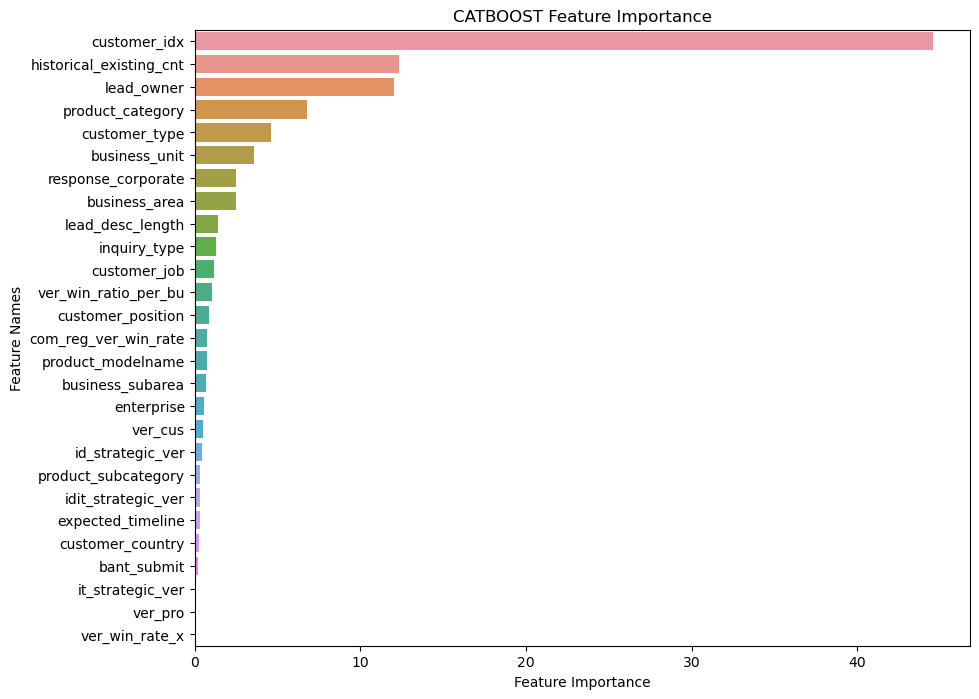

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(best_models[0].get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,'CATBOOST')